# CCF Planet Finder
### Purpose: to find planet in data cube when you cannot see it with your eyes


In [4]:
import glob
from scipy.signal import convolve, boxcar
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os, sys
import time
from astropy.table import Table
from astropy.io import fits
import copy
import scipy.io as spio
import matplotlib.image as mpimg


### Read in fits data cube
#### primary hdu contains the data

In [6]:
hdul = fits.open('s190526_a022002_tlc_Kbb_050.fits')
hdul.info()
cube = hdul[0].data
#pixel = cube[9,32,:]

Filename: s190526_a022002_tlc_Kbb_050.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     443   (1665, 64, 19)   float32   
  1                1 ImageHDU         8   (1665, 64, 19)   float32   
  2                1 ImageHDU         8   (1665, 64, 19)   uint8   


### Need the wavlength information from the fits file 

In [7]:
Wavelengths = hdul[0].header['CRVAL1'] + np.arange(hdul[0].header['NAXIS1']) * hdul[0].header['CDELT1']
#this is for OSIRIS

### Need model to cross correlate for the planet signal 
#### Model needs to be close in spectral type to planet you're searching for 

In [8]:
#need to read in 51 Eri spec for GJ 504 b
erib = '51Erib_model_osiris_k.sav' #sav data file
moreerib = spio.readsav(erib, python_dict=True, verbose=True) #seeing whats in it
eriwaves = moreerib['wavek'] #getting wavelength info
erifluxes = moreerib['f_mod_k'] #getting flux info


--------------------------------------------------
Date: Mon Mar 21 10:51:44 2016
User: quinn
Host: cappuccino.physics.ucsd.edu
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2.3
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 2 are of type VARIABLE
--------------------------------------------------
Available variables:
 - wavek [<class 'numpy.ndarray'>]
 - f_mod_k [<class 'numpy.ndarray'>]
--------------------------------------------------


### RV information

In [9]:
#RV of Star km/s (go to simbad)
rv = -27
#baryrv may 26 km/s: (need mjd-obs and to convert to JD)
baryrv = -21.4
#speed of light in km/s:
c_kms = 299792


### Interpolate model to match RV

In [10]:
#assuming rv same as host star and keeping it constant
wvs_shifted= eriwaves*(1 - ((rv-baryrv) / c_kms))
#interpolating the model
spline = scipy.interpolate.splrep(eriwaves, erifluxes)
#taking above model and creating a doppler shifted spectra of the model
shifted_spec = scipy.interpolate.splev(wvs_shifted, spline, der=0)


### Smooth model and remove spikes

In [12]:
#smoothing the model spectra to get the continuum
smoothedmod = scipy.ndimage.filters.uniform_filter(shifted_spec,size=200)
#subtracting the continuum out
filtmod = shifted_spec - smoothedmod
#this method caused some sharp spikes, so here we identify which parts are spikes
spikes = np.where(np.abs(filtmod) > 3*np.std(filtmod)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
#We make the spikes equal to the median of the spectra
filtmod[spikes]=np.median(filtmod)


In [13]:
#define array for 2d ccf image
corr_im = np.zeros((19,64))
#print(cube.shape)


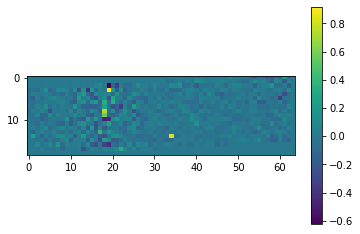

In [14]:
#looping through cubes (0,18) (0,63)
for x in range(0,18):
    for y in range(0,63):
        #print(cube[x,y,:])
        smoothed=scipy.ndimage.filters.uniform_filter(cube[x,y,:],size=200) #smoothing pixel flux
        filt = cube[x,y,:] - smoothed #flatten the fluxes
        spikes = np.where(np.abs(filt) > 2*np.std(filt)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
        filt[spikes]=np.median(filt) #setting spikes to median value
        ccfval = np.sum(filt * filtmod) / np.sqrt(np.sum((filtmod) ** 2)) #cross correlate model with data
        #print(ccfval)
        corr_im[x,y] = ccfval   #put ccf value into array
        #plt.plot(Wavelengths, filt)
        #plt.show()
        #print(spikes)
plt.imshow(corr_im)
plt.colorbar()
plt.show()
